In [639]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score 

import statsmodels.api as sm
from scipy import stats

In [640]:
abbrev = pd.read_csv("data/abbrev.csv")
abbrev.columns

Index(['Unnamed: 0', 'household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area', 'prc_obese',
       'domestic_passengers', 'intl_passengers', 'deaths', 'cases_march1',
       'cases_march15', 'cases_april1', 'ten_plus', 'order', 'density',
       'death_prc'],
      dtype='object')

In [641]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)

In [643]:
predictors = ['household_size', 'empl_agriculture', 'empl_professional','empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
              'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population', 'pop_65_plus', 'health_ins', 'area', 
              'domestic_passengers', 'intl_passengers', 'prc_obese', 'ten_plus', 'order', 'density', 'cases_march1',
             'cases_march15']
# omitting april1 cases data, since it's pretty much perfectly correlated...

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_march1')
predictors_noCaseData.remove('cases_march15')
predictors_noCaseData

['household_size',
 'empl_agriculture',
 'empl_professional',
 'empl_social',
 'empl_services',
 'empl_manufacturing',
 'empl_retail',
 'prc_fam_poverty',
 'avg_income',
 'prc_public_transp',
 'population',
 'pop_65_plus',
 'health_ins',
 'area',
 'domestic_passengers',
 'intl_passengers',
 'prc_obese',
 'ten_plus',
 'order',
 'density']

In [644]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


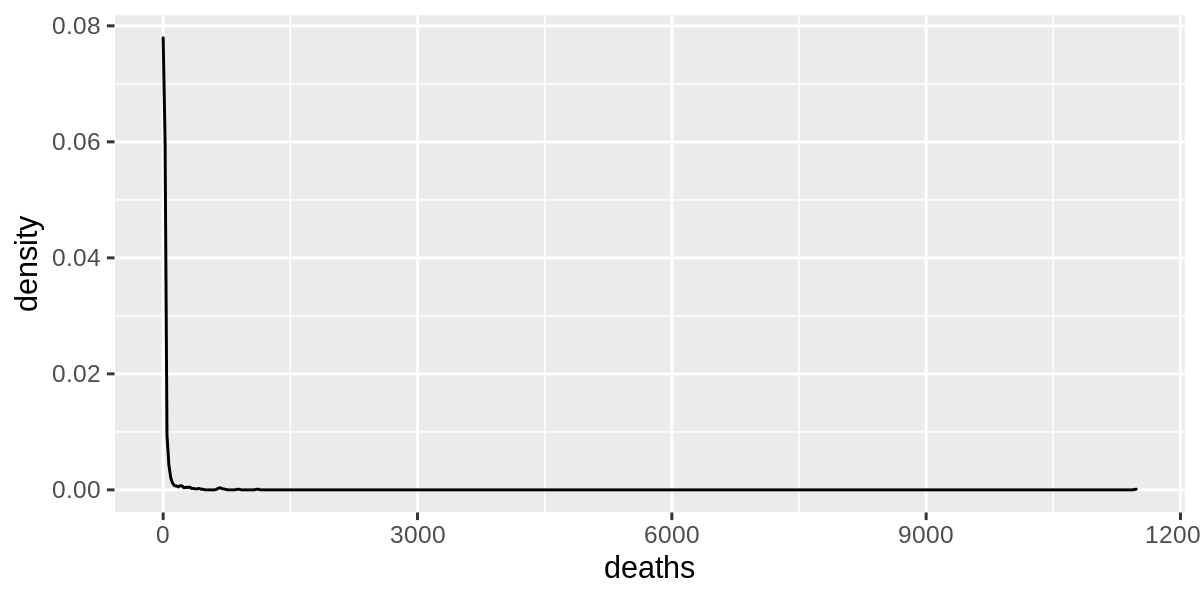

In [645]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

library(ggplot2)
ggplot(abbrev, aes(deaths)) + geom_density()

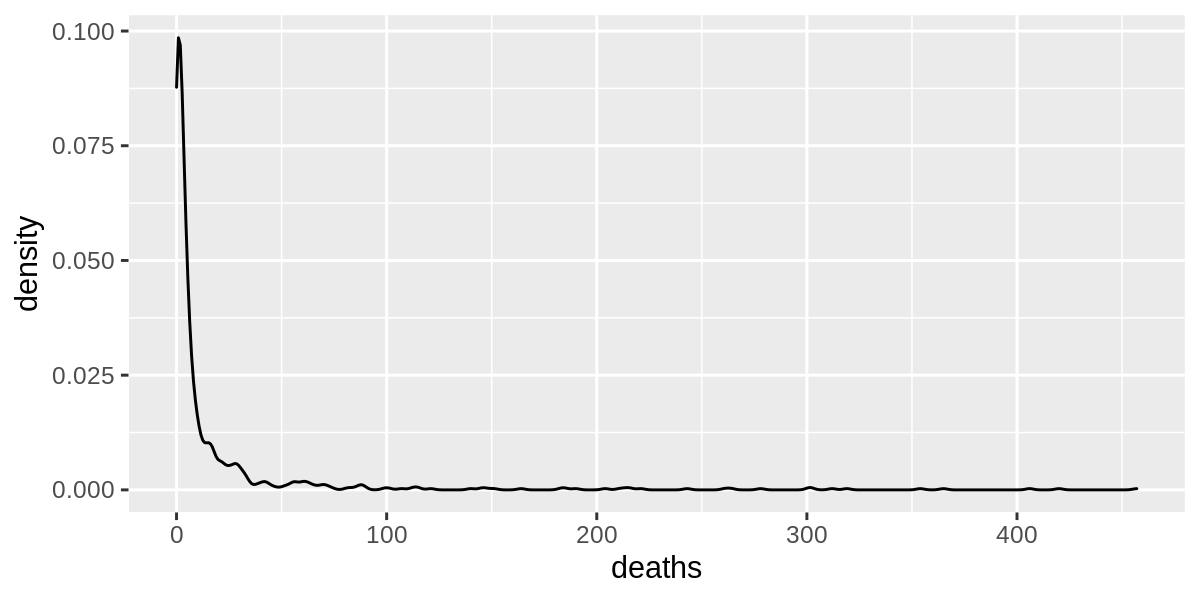

In [646]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(deaths)) + geom_density()

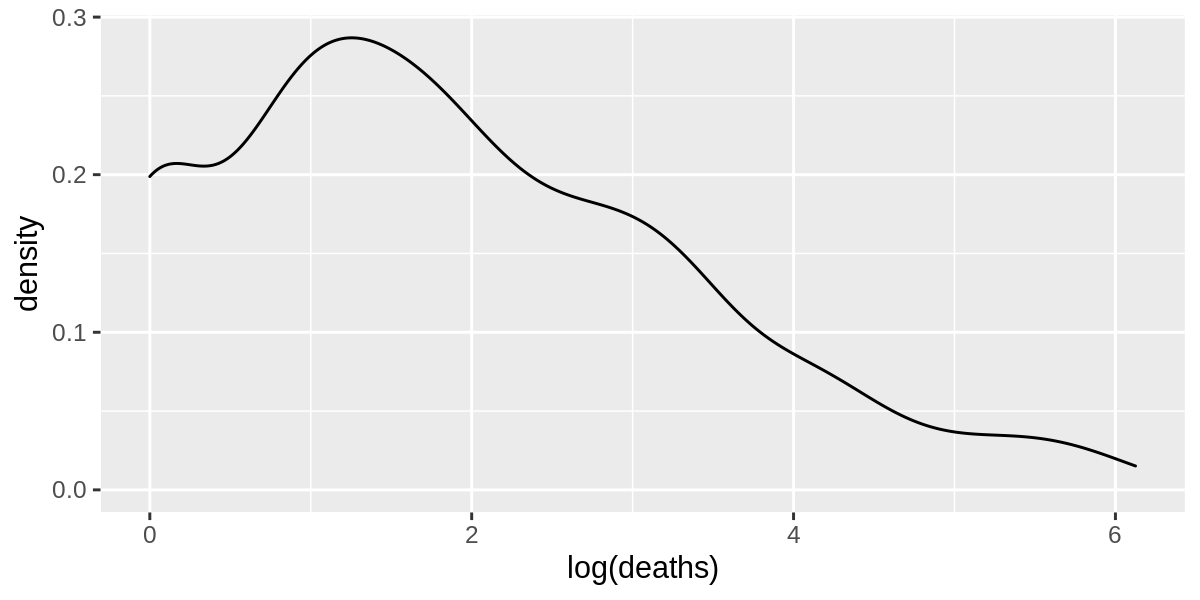

In [647]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(log(deaths))) + geom_density()

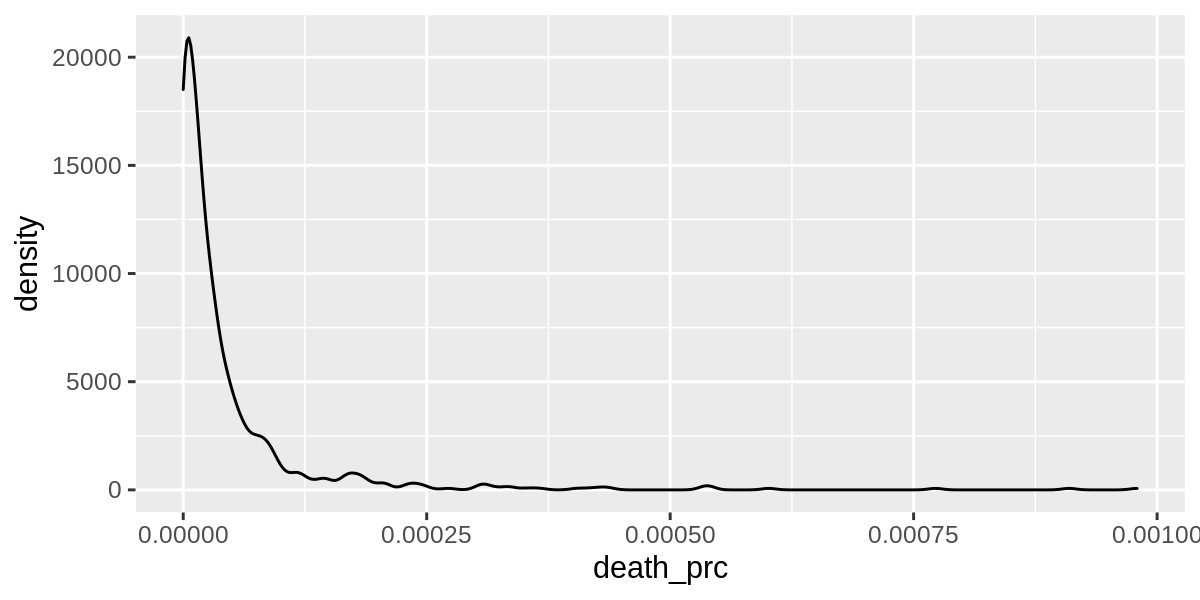

In [648]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(death_prc)) + geom_density()

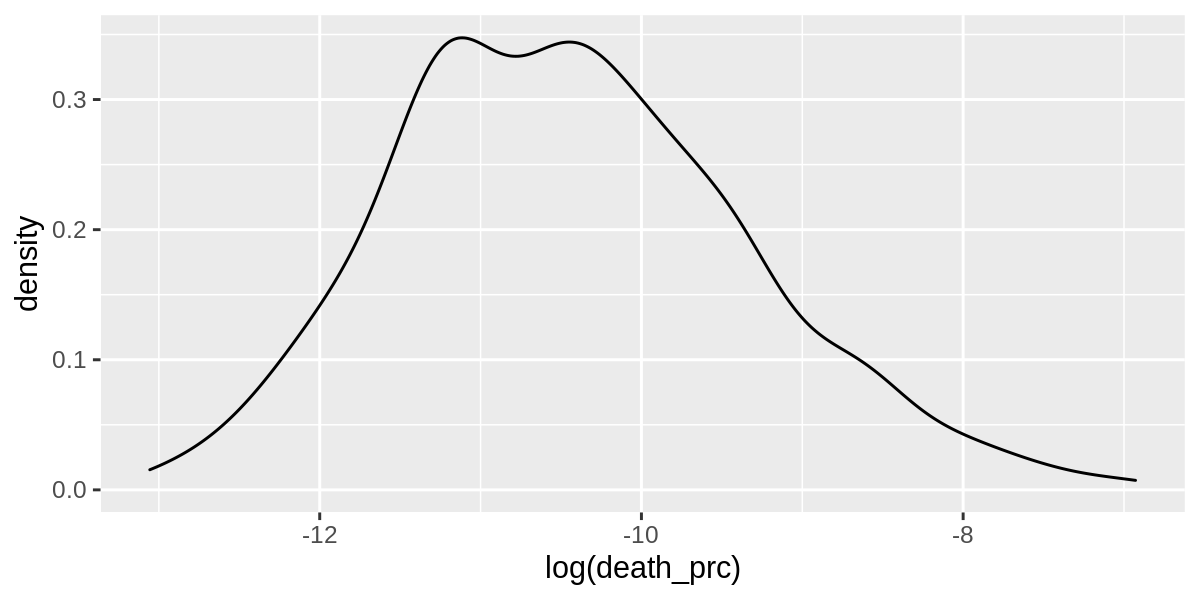

In [649]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(log(death_prc))) + geom_density()

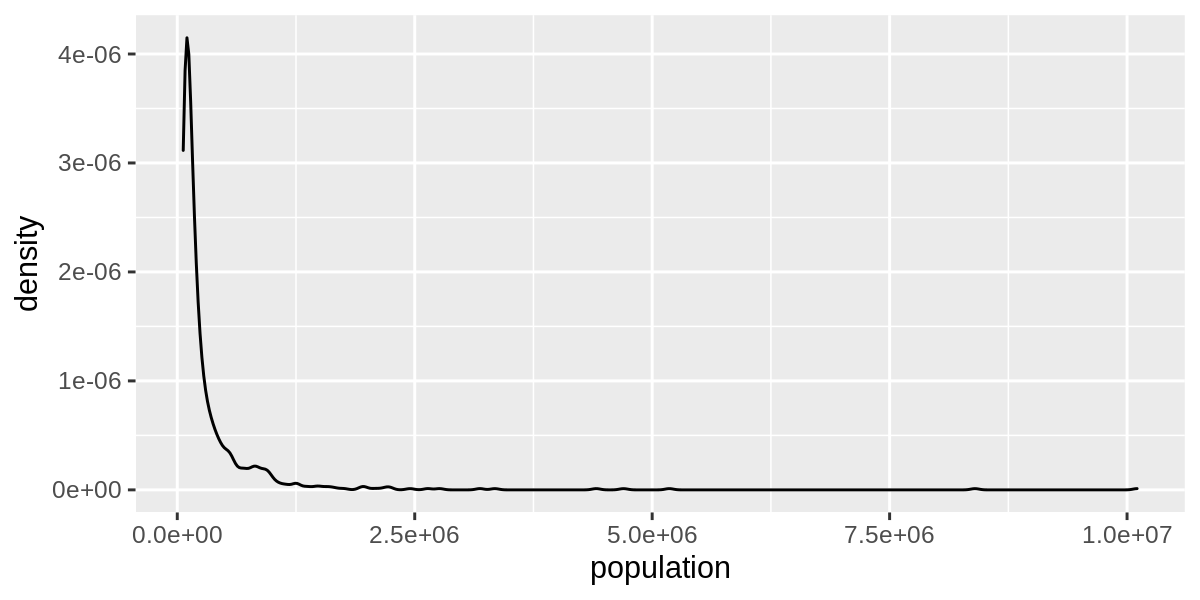

In [650]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(population)) + geom_density()
# try log-transforming population

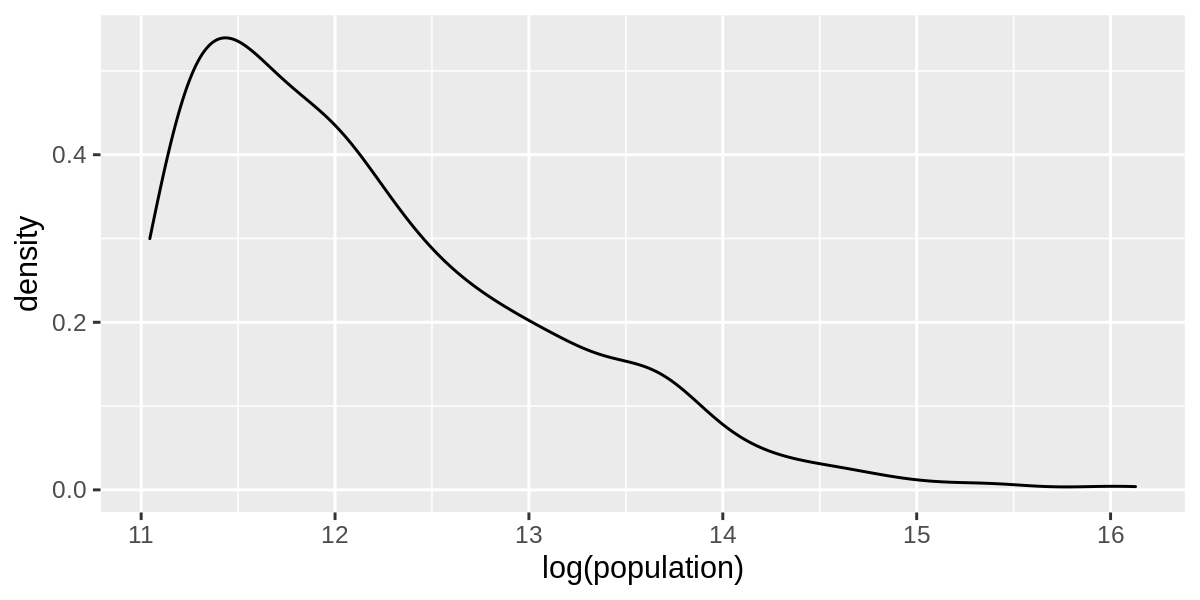

In [651]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(population))) + geom_density()

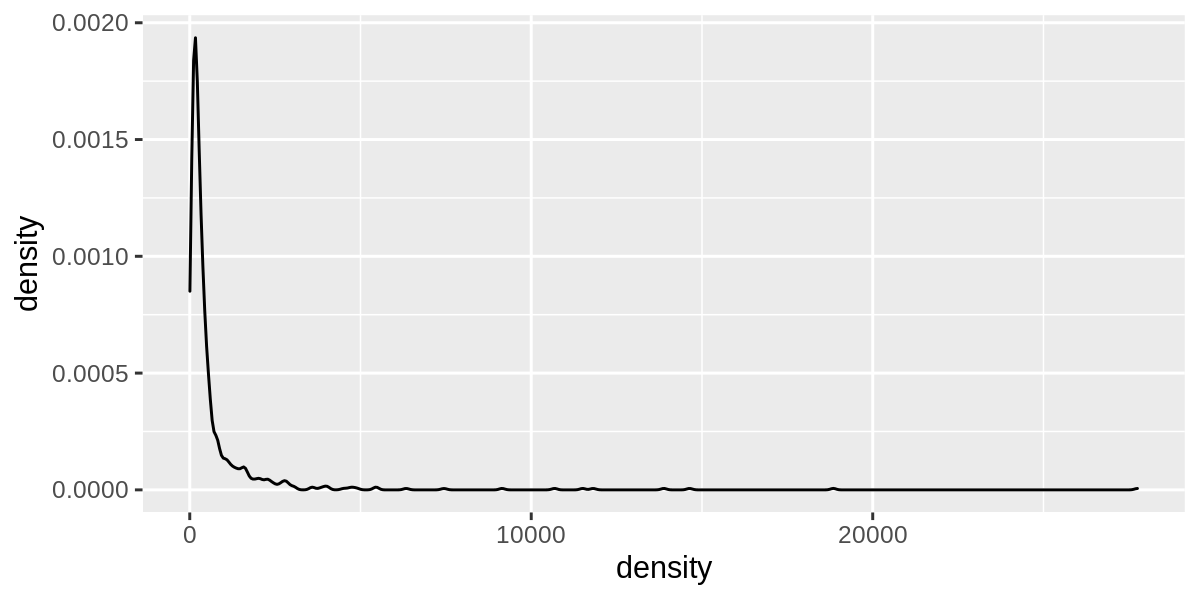

In [652]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(density)) + geom_density()

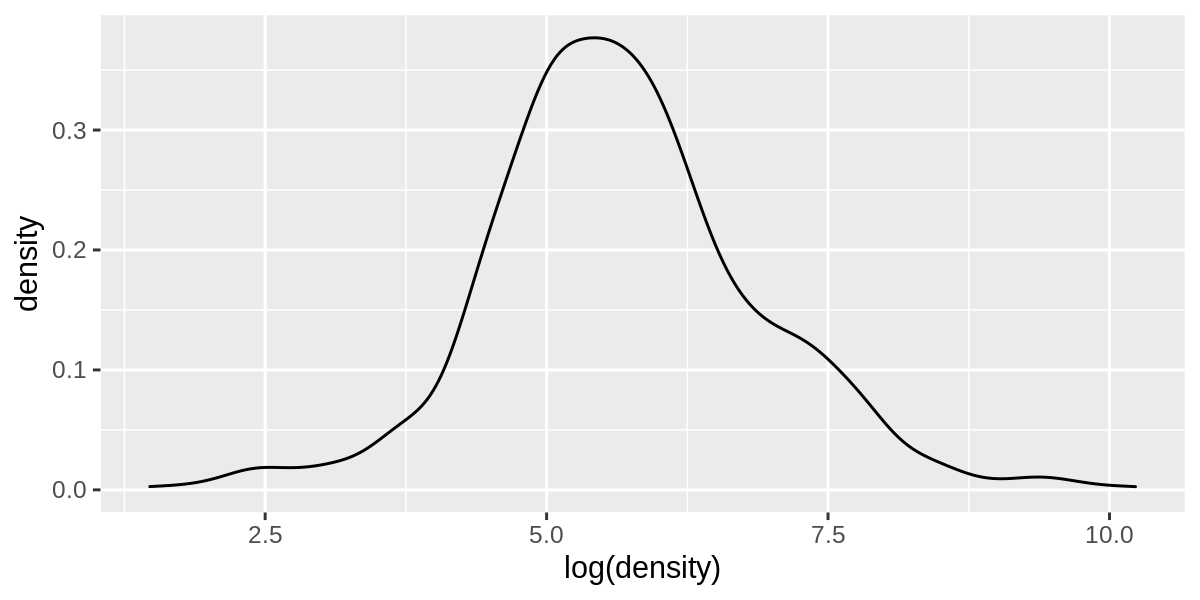

In [653]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(density))) + geom_density()
# much more normal! try log transforming density, too

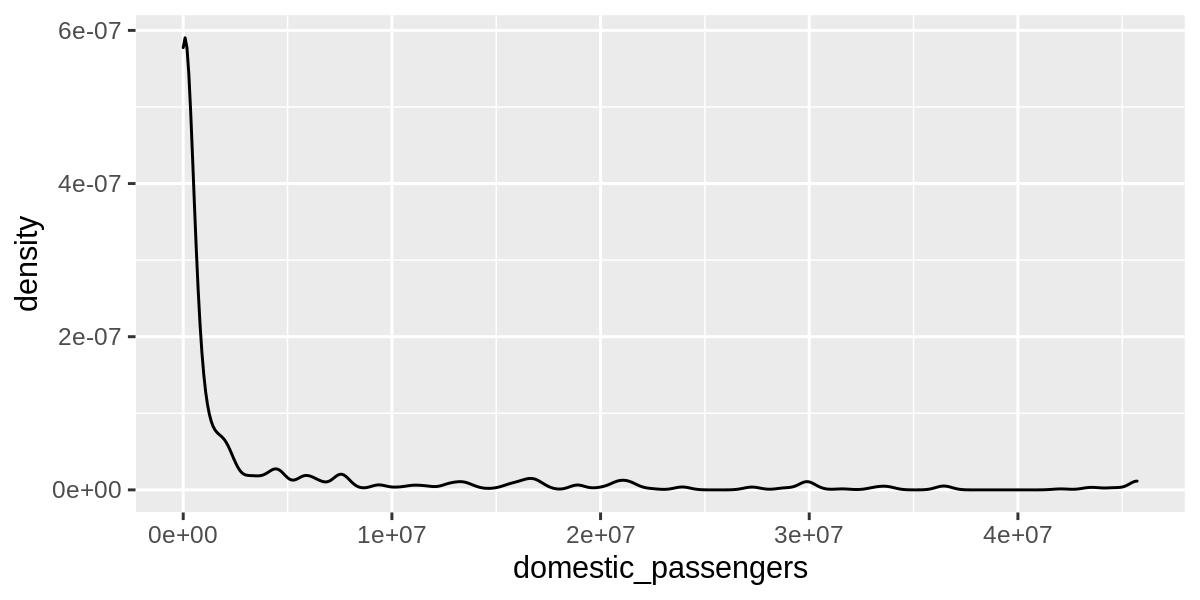

In [654]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(domestic_passengers)) + geom_density()
# log transform domestic_passengers, too

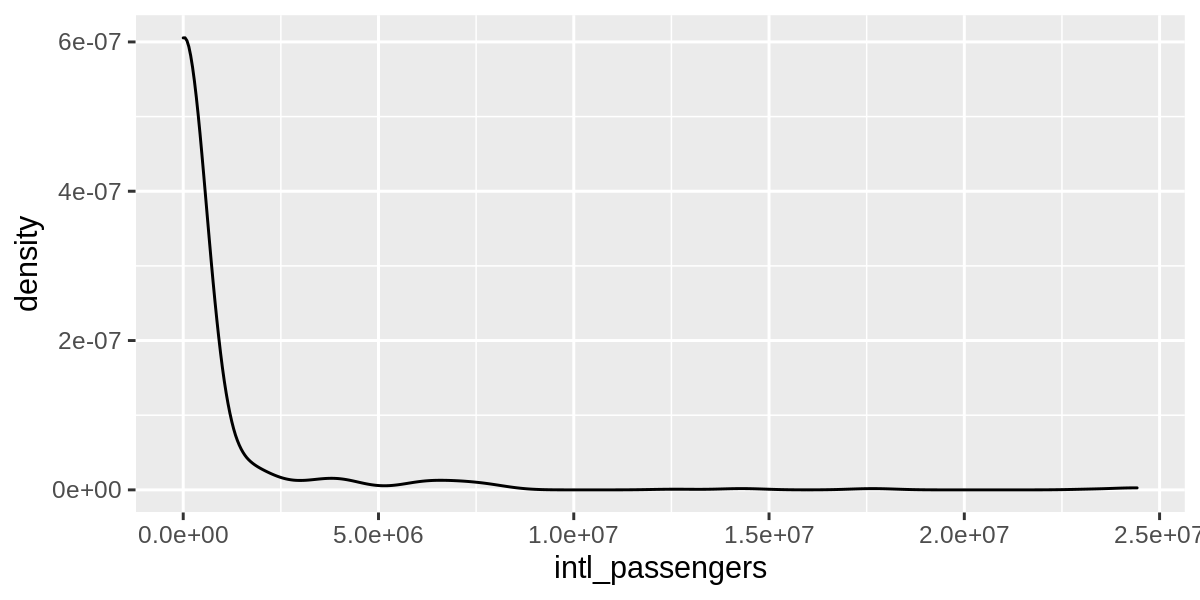

In [655]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(intl_passengers)) + geom_density()
# and international passengers

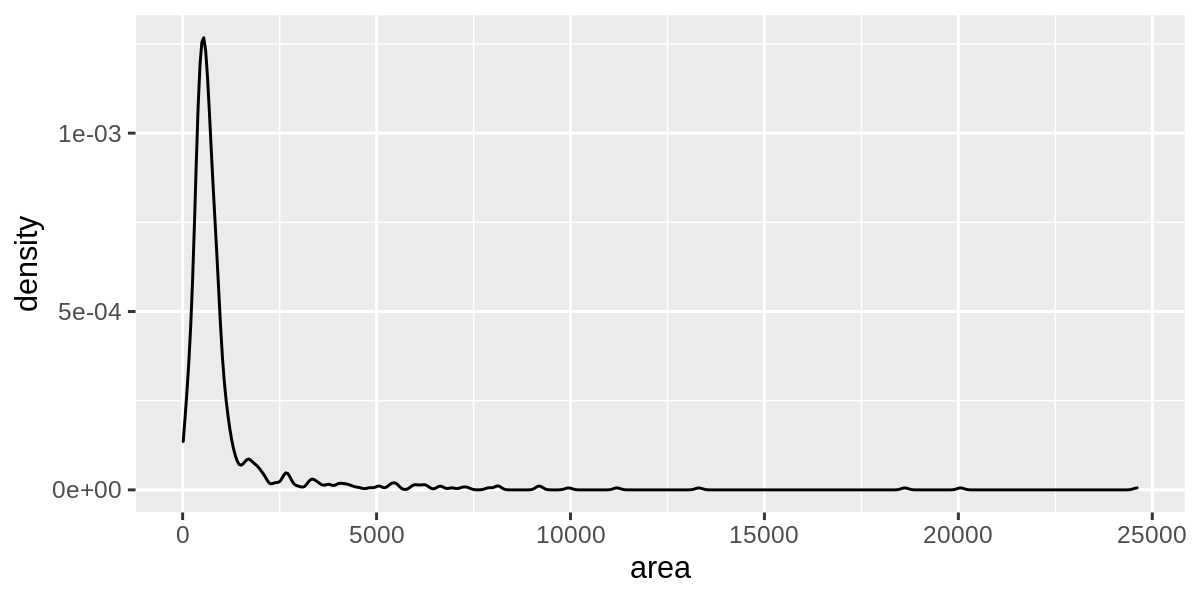

In [656]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(area)) + geom_density()
# and area

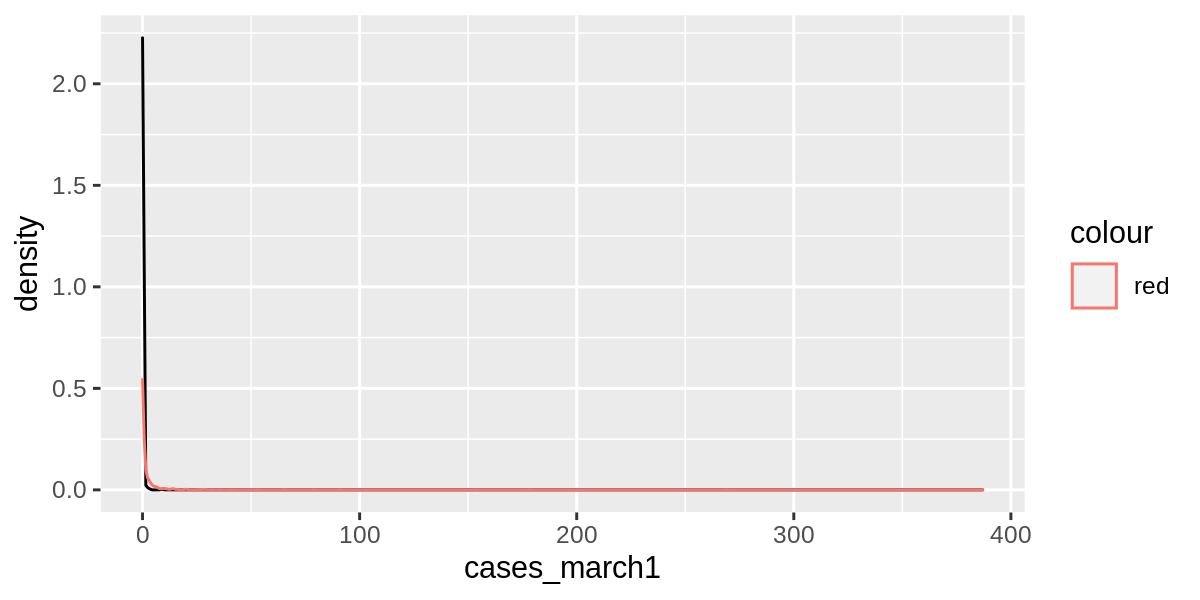

In [657]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_density(aes(cases_march1)) +
geom_density(aes(cases_march15, color="red")) 
# and case numbers

In [658]:
abbrev[["density", "area", "population", "intl_passengers", "domestic_passengers", 
       "cases_march1", "cases_march15"]].describe()

,density,area,population,intl_passengers,domestic_passengers,cases_march1,cases_march15
count,823.000000,823.000000,8.230000e+02,8.230000e+02,8.230000e+02,823.000000,823.000000
mean,680.411847,1072.085128,3.381622e+05,6.392778e+05,4.013013e+06,0.034022,3.403402
std,1702.363895,1819.334447,6.444629e+05,2.440155e+06,8.866051e+06,0.377351,19.561994
min,4.372986,15.030000,6.260700e+04,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,140.207786,439.090000,9.591600e+04,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,271.494496,631.520000,1.593370e+05,0.000000e+00,2.980000e+05,0.000000,0.000000
75%,557.809007,911.795000,3.306250e+05,0.000000e+00,2.180000e+06,0.000000,2.000000
max,27750.695523,24607.900000,1.010552e+07,2.442400e+07,4.571100e+07,9.000000,387.000000


In [659]:
abbrev.loc[abbrev["intl_passengers"] == 0, "intl_passengers"] = 0.0000001
abbrev.loc[abbrev["domestic_passengers"] == 0, "domestic_passengers"] = 0.0000001
abbrev.loc[abbrev["cases_march1"] == 0, "cases_march1"] = 0.0000001
abbrev.loc[abbrev["cases_march15"] == 0, "cases_march15"] = 0.0000001

transform = ["population", "density", "intl_passengers", "domestic_passengers", "area", 
            "cases_march1", "cases_march15"]
for field in transform:
    abbrev["log_"+field] = np.log1p(abbrev[field])

In [660]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area', 'prc_obese',
       'domestic_passengers', 'intl_passengers', 'deaths', 'cases_march1',
       'cases_march15', 'cases_april1', 'ten_plus', 'order', 'density',
       'death_prc', 'log_population', 'log_density', 'log_intl_passengers',
       'log_domestic_passengers', 'log_area', 'log_cases_march1',
       'log_cases_march15'],
      dtype='object')

In [661]:
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
print(log_predictors)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'prc_obese', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area', 'log_cases_march1', 'log_cases_march15']


In [662]:
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_march1')
log_predictors_noCaseData.remove('log_cases_march15')
print(log_predictors_noCaseData)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'prc_obese', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area']


### Linear Regression

In [663]:
# dependent variable = deaths

lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["deaths"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["deaths"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["deaths"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["deaths"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["deaths"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["deaths"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["deaths"]))

no case data R2:  0.5409614115483582 
with case data R2:  0.7292119630161213 
log predictors no case data R2:  0.3470212945681367 
log predictors with case data R2:  0.3611453977701736


In [666]:
print("variable\tcoeff with cases\t coeff without cases")
for a,b,c in zip(predictors, lrm.coef_, lrm_noCases.coef_):
    print(a, "\t", b, "\t", c)
for x in range(len(predictors)-2, len(predictors)):
    print(predictors[x], "\t", lrm.coef_[x], "\tNA")

variable	coeff with cases	 coeff without cases
household_size 	 75.28455198384852 	 118.85700563563609
empl_agriculture 	 0.9463378875843896 	 2.9267900690813384
empl_professional 	 -11.226452943399323 	 -18.914288142132474
empl_social 	 3.524727877492399 	 4.609800149290528
empl_services 	 -0.8392296432919633 	 1.5983657880486764
empl_manufacturing 	 -0.7999375079591012 	 -0.9074980115878674
empl_retail 	 1.6435036257164646 	 0.9669436819084098
prc_fam_poverty 	 -9.817197786475367 	 -12.651991372969226
avg_income 	 -0.004277157223089654 	 -0.0028960459271158315
prc_public_transp 	 -16.196100940107527 	 -4.629386456278703
population 	 0.0001858342985092068 	 0.0002306781427170589
pop_65_plus 	 4.877292414781905 	 7.186224242078441
health_ins 	 1.6044195906683119 	 0.033148299744546715
area 	 -0.0034849972521730785 	 -0.007286816861073862
domestic_passengers 	 -5.14458760182182e-06 	 -1.2674636348336003e-05
intl_passengers 	 5.78048726376177e-06 	 4.75151898168815e-05
prc_obese 	 1.1585

In [667]:
# dependent variable: deaths as percentage of population

lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["death_prc"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["death_prc"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["death_prc"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["death_prc"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["death_prc"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["death_prc"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["death_prc"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["death_prc"]))

no case data R2:  0.4178492425118028 
with case data R2:  0.47027679211770174 
log predictors no case data R2:  0.36022165029475284 
log predictors with case data R2:  0.39968785276688334


#### Linear Regression with TransformedTargetRegressor

transforms the dependent variable (here using natural logarithm) before regression

+ https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor

In [669]:
ttr = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)

ttr.fit(abbrev[predictors], abbrev["deaths"])
ttr_lrm = ttr.score(abbrev[predictors], abbrev["deaths"])

ttr.fit(abbrev[predictors_noCaseData], abbrev["deaths"])
ttr_lrm_noCases = ttr.score(abbrev[predictors_noCaseData], abbrev["deaths"])

ttr.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_log_lrm = ttr.score(abbrev[log_predictors], abbrev["deaths"])

ttr.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
ttr_log_lrm_noCases = ttr.score(abbrev[log_predictors_noCaseData], abbrev["deaths"])

print("no case data R2: ", ttr_lrm_noCases, 
      "\nwith case data R2: ", ttr_lrm, 
      "\nlog predictors no case data R2: ", ttr_log_lrm_noCases, 
      "\nlog predictors with case data R2: ", ttr_log_lrm)

no case data R2:  -8.151688461559898 
with case data R2:  -29.94517595783297 
log predictors no case data R2:  0.8052465912711629 
log predictors with case data R2:  0.9217995123708174


In [671]:
# compare those with with r2=.910 and r2=0.799 (log predictors, dependent variable=deaths)
ttr1 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr1.fit(abbrev[log_predictors], abbrev["deaths"])

ttr2 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr2.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])

print("variable\tcoeff with cases\tcoeff without cases")
for a, b,c in zip(log_predictors, ttr1.regressor_.coef_, ttr2.regressor_.coef_):
    print(a, "\t", b, "\t", c)
for x in range(len(log_predictors)-2, len(predictors)):
    print(log_predictors[x], "\t", ttr1.regressor_.coef_[x], "\tNA")

variable	coeff with cases	coeff without cases
household_size 	 -0.04723494993663047 	 -0.020447450375906596
empl_agriculture 	 -0.005193266773172906 	 -0.004242014021971543
empl_professional 	 -0.052586359338524916 	 -0.055358071645736605
empl_social 	 -0.0046803147126670405 	 -0.005057945791014147
empl_services 	 -0.04228634681727966 	 -0.04345583321821593
empl_manufacturing 	 0.002618884943894554 	 0.0016925708526038241
empl_retail 	 -0.004644014025134231 	 -0.007034038305842989
prc_fam_poverty 	 0.03114841049493764 	 0.03253719579051102
avg_income 	 1.6647363753040372e-05 	 1.779627935256635e-05
prc_public_transp 	 0.042855690921920604 	 0.047259516060432244
pop_65_plus 	 0.028655475169238543 	 0.03074313088063399
health_ins 	 0.02742719629772489 	 0.025547024996185403
prc_obese 	 0.02461255463673085 	 0.02240473445216618
ten_plus 	 0.06829936364976379 	 0.07386378381355549
order 	 0.02185688939499404 	 0.021704981915922194
log_population 	 -0.8871036189436268 	 -0.6992924178830646


while the valaues of the coefficients change between model that uses case data and the one that doesn't, for most of the variables the polarity of the coefficient is the same and the value isn't wildly different between the two models

In [672]:
exam = abbrev.copy()
exam["fitted"] = ttr1.regressor_.predict(abbrev[log_predictors])
exam["pred"] = ttr1.inverse_func(ttr1.regressor_.predict(abbrev[log_predictors]))

exam["fitted_noCases"] = ttr2.regressor_.predict(abbrev[log_predictors_noCaseData])
exam["pred_noCases"] = ttr2.inverse_func(ttr2.regressor_.predict(abbrev[log_predictors_noCaseData]))

In [673]:
exam[["pred", "pred_noCases", "deaths"]].describe()

,pred,pred_noCases,deaths
count,823.000000,823.000000,823.000000
mean,23.933623,21.328873,38.071689
std,308.095085,235.360215,408.374275
min,-0.638372,-0.692413,0.000000
25%,1.492194,1.545885,1.000000
50%,3.699345,3.783330,3.000000
75%,9.050546,9.147288,13.000000
max,8786.618848,6674.896016,11477.000000


/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
R[write to console]: `geom_smooth()` using formula 'y ~ x'



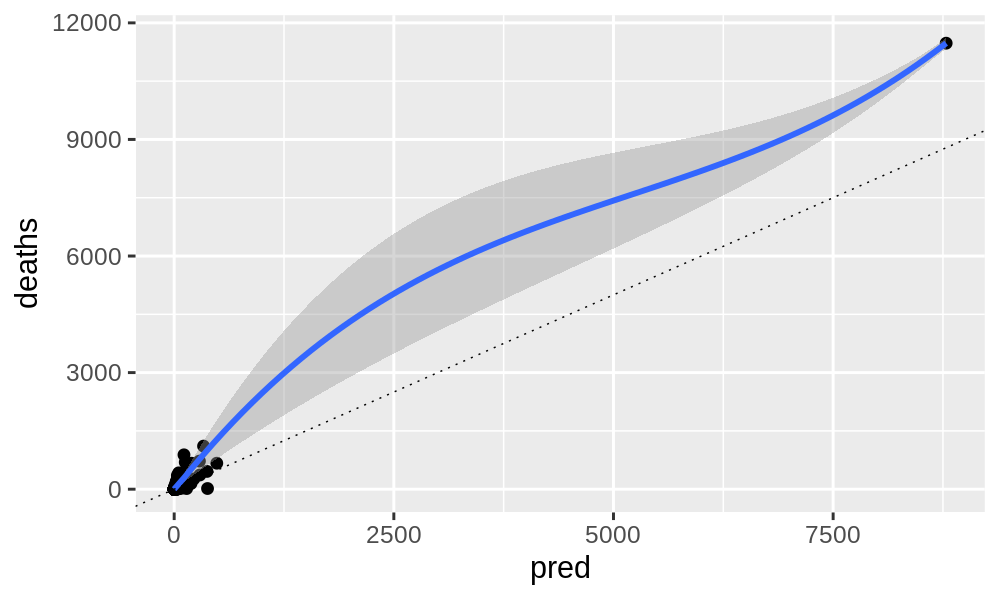

In [674]:
%%R -i exam -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = 1) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



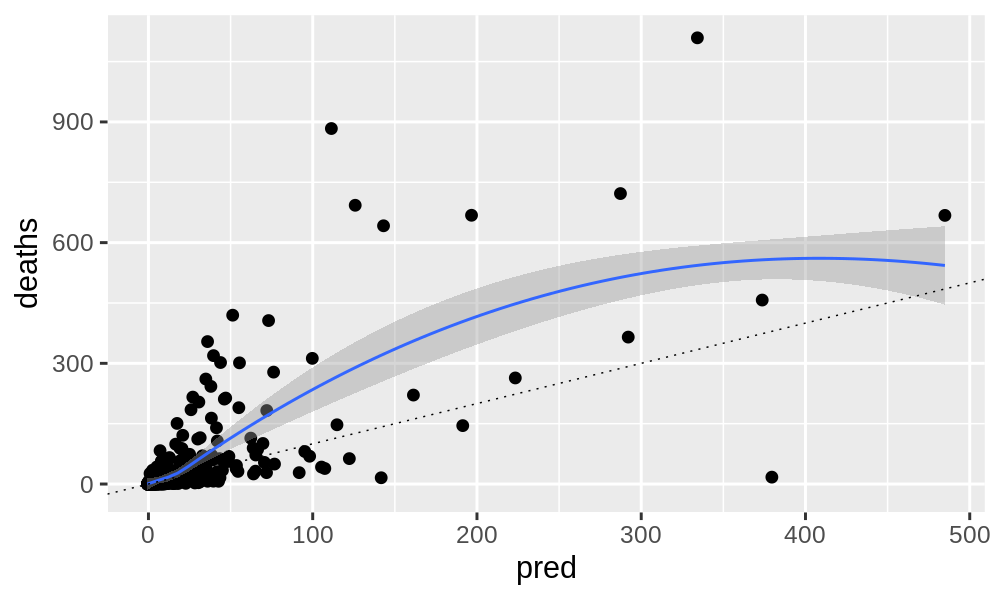

In [675]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$count != "New York County",], aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



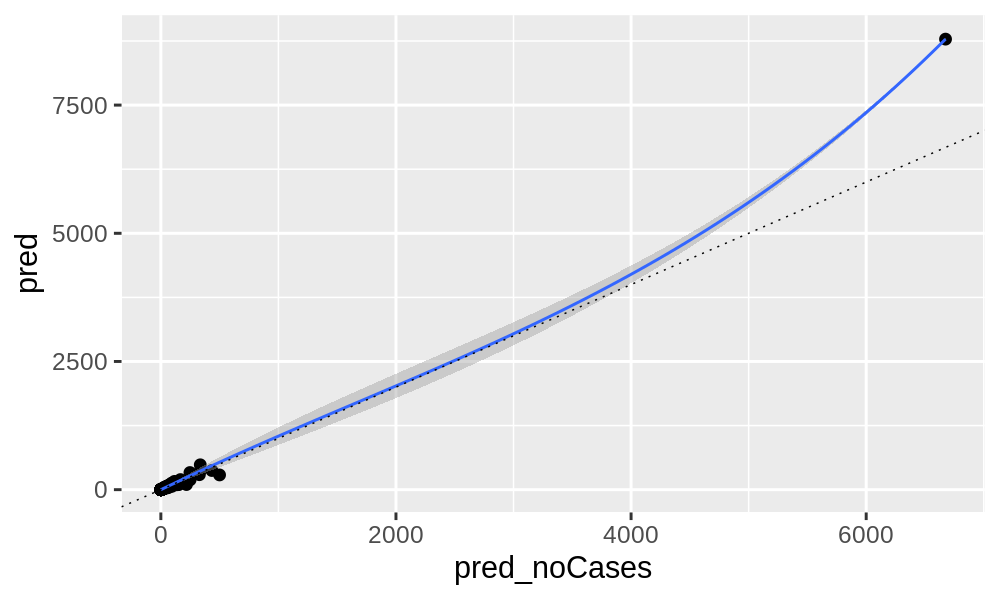

In [676]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=pred_noCases, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



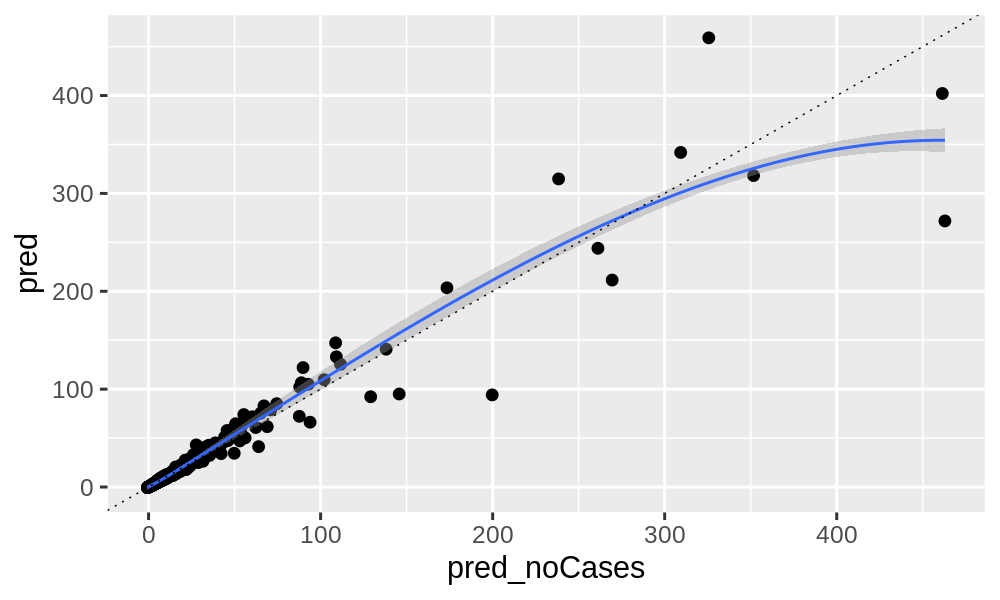

In [620]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$county != "New York County",], aes(x=pred_noCases, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

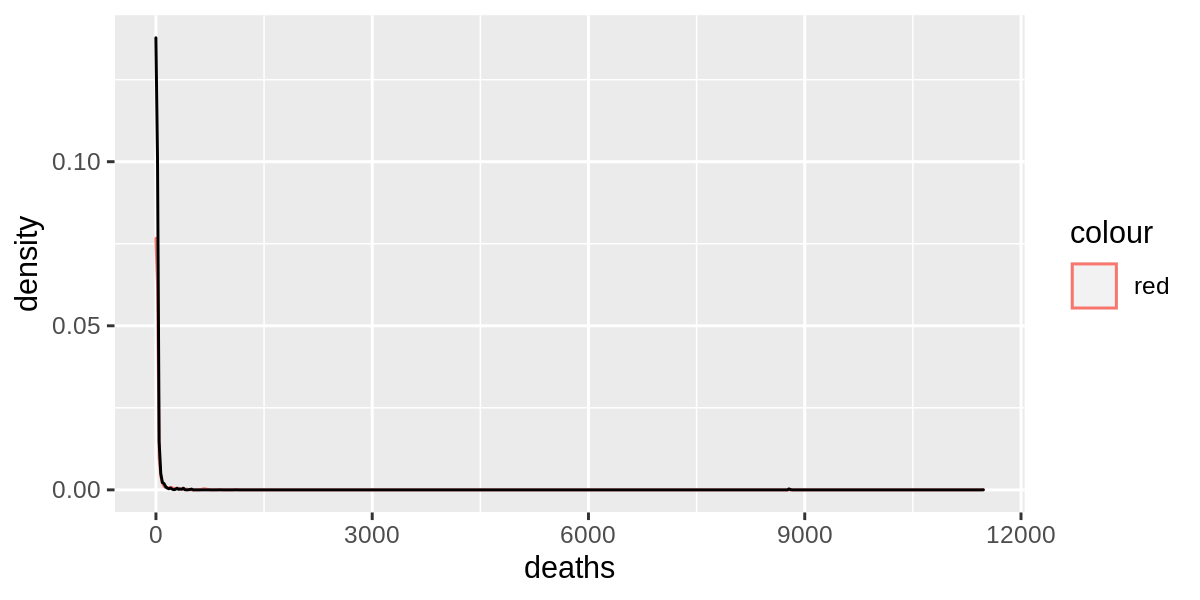

In [677]:
%%R -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

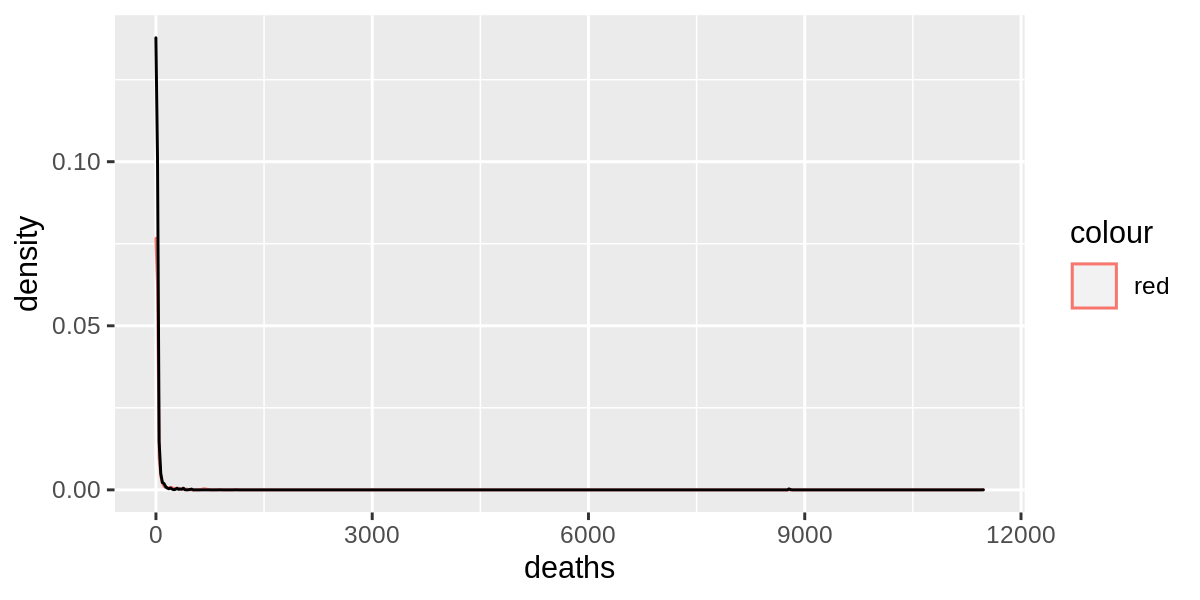

In [678]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

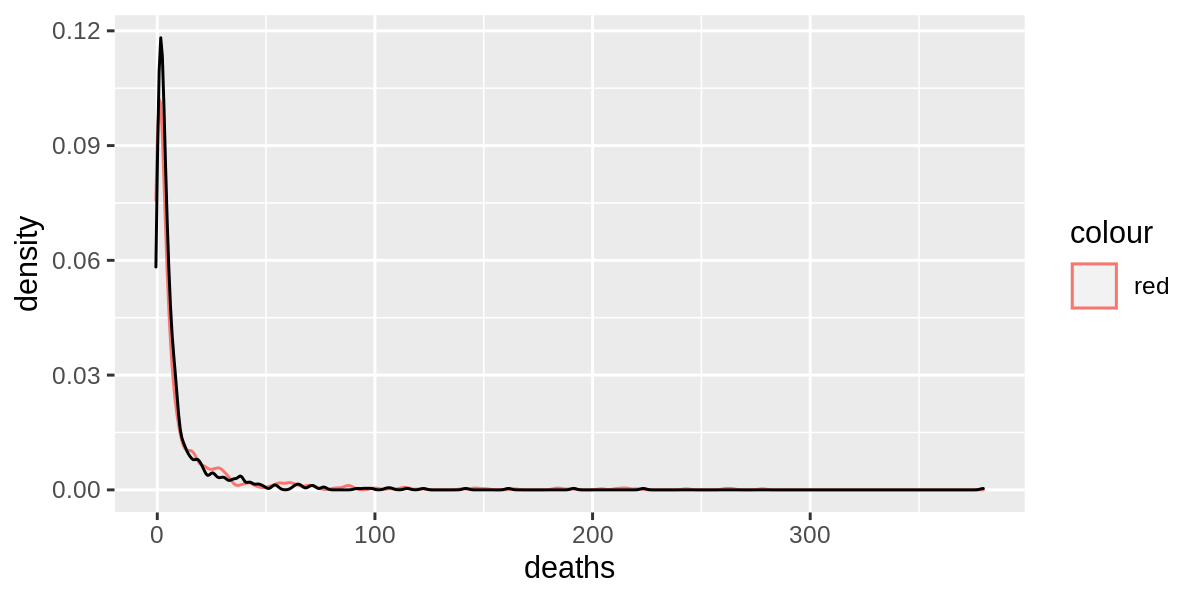

In [679]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam[exam$deaths < 300,]) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

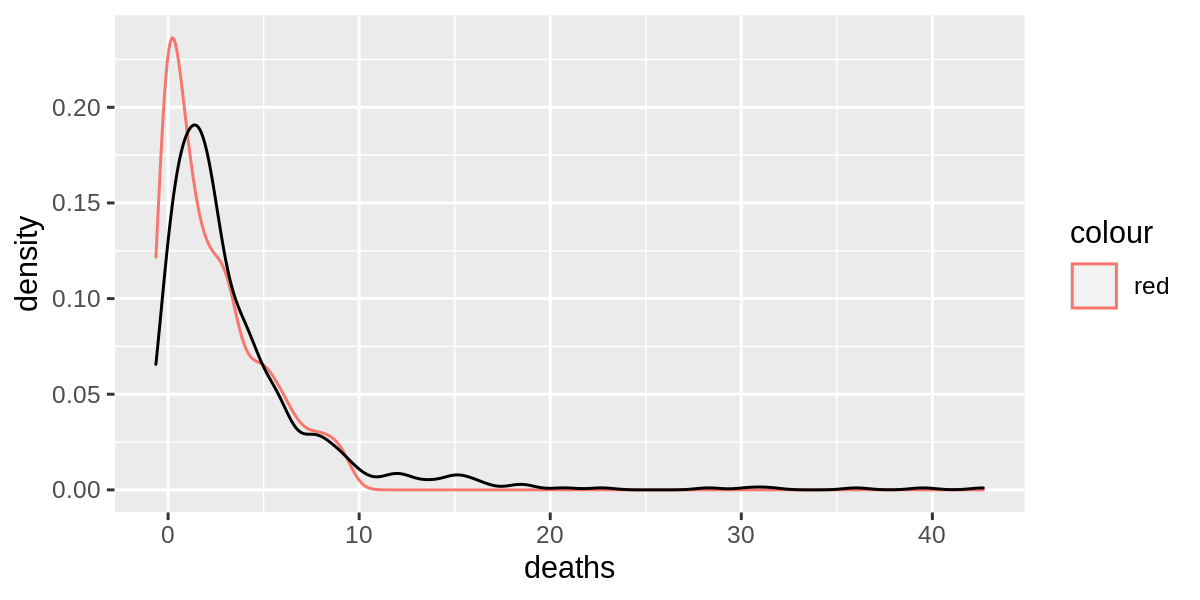

In [680]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam[exam$deaths < 10,]) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

In [681]:
# check the model using R-style plots
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# https://medium.com/@vikashrajluhaniwal/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

import seaborn as sns
import matplotlib.pyplot as plt
#import scipy.stats as stats

#import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [682]:
exam["residuals"] = exam["deaths"] - exam["pred"]
exam["residuals_noCases"] = exam["deaths"] - exam["pred_noCases"]

In [683]:
exam[["residuals", "residuals_noCases", "deaths", "pred", "pred_noCases"]].describe()

,residuals,residuals_noCases,deaths,pred,pred_noCases
count,823.000000,823.000000,823.000000,823.000000,823.000000
mean,14.138066,16.742816,38.071689,23.933623,21.328873
std,113.319601,179.438778,408.374275,308.095085,235.360215
min,-362.532836,-321.488066,0.000000,-0.638372,-0.692413
25%,-1.914573,-2.027777,1.000000,1.492194,1.545885
50%,0.019571,0.019872,3.000000,3.699345,3.783330
75%,3.052429,2.976966,13.000000,9.050546,9.147288
max,2690.381152,4802.103984,11477.000000,8786.618848,6674.896016


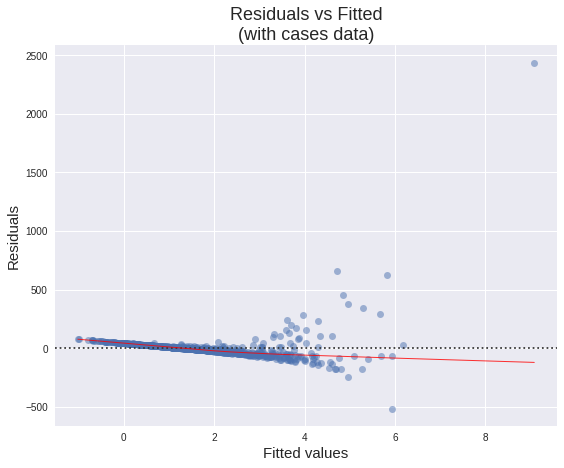

In [684]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted"], exam["residuals"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(with cases data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

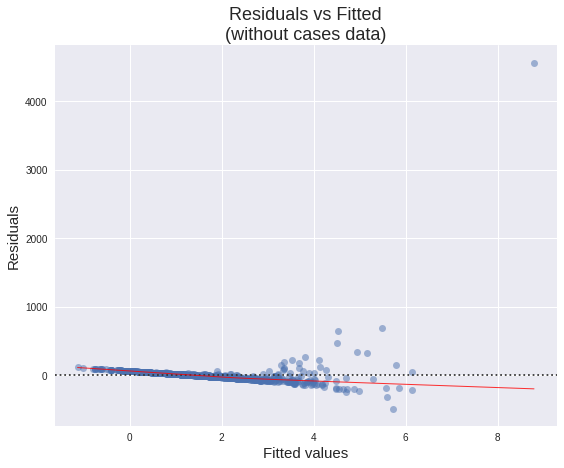

In [629]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted_noCases"], exam["residuals_noCases"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without cases data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

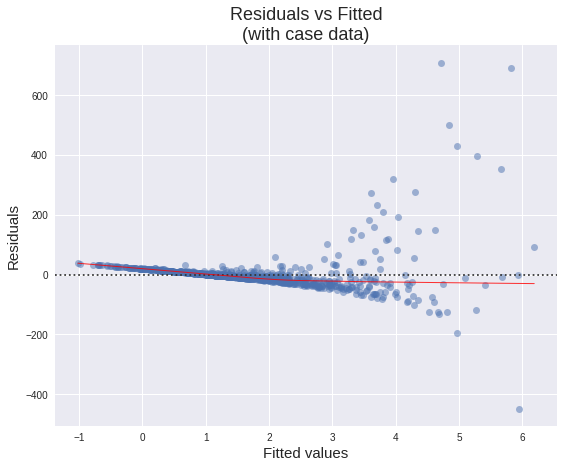

In [685]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted"], 
                                  exam.loc[exam["deaths"]<5000,"residuals"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(with case data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# looking at the same (still heterskedasticitic) when removing NY County (a spectacular outlier)

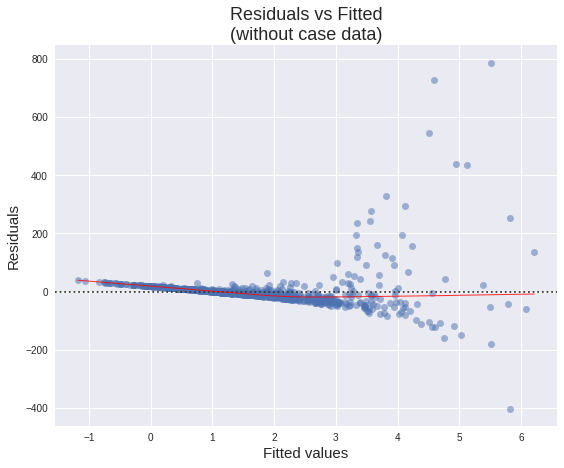

In [686]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted_noCases"], 
                                  exam.loc[exam["deaths"]<5000,"residuals_noCases"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without case data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# same sort of heteroskedasticity as with case data

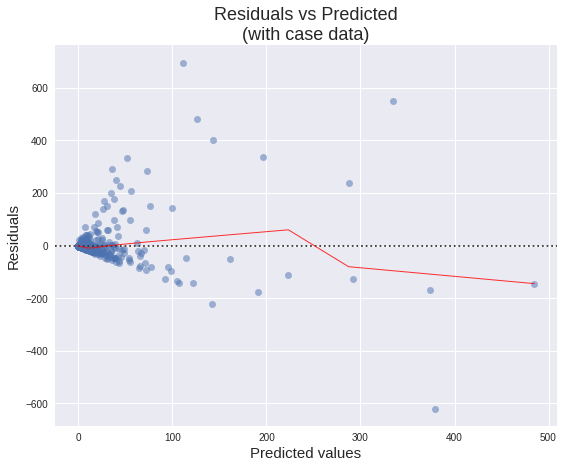

In [687]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"pred"], 
                                  exam.loc[exam["deaths"]<5000,"residuals"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Predicted\n(with case data)')
plot_lm_1.axes[0].set_xlabel('Predicted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

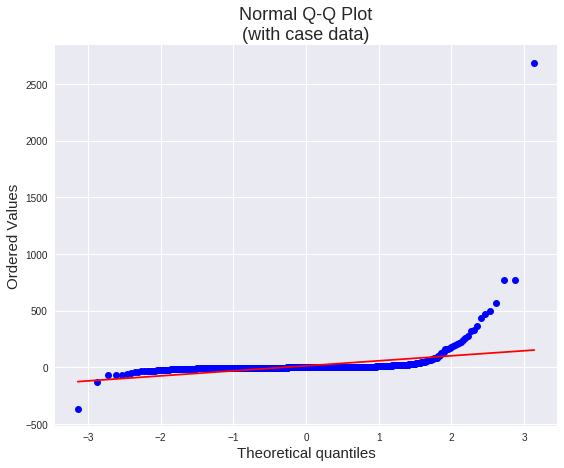

In [688]:
plt.figure(figsize=(9,7))
stats.probplot(exam["residuals"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(with case data)');

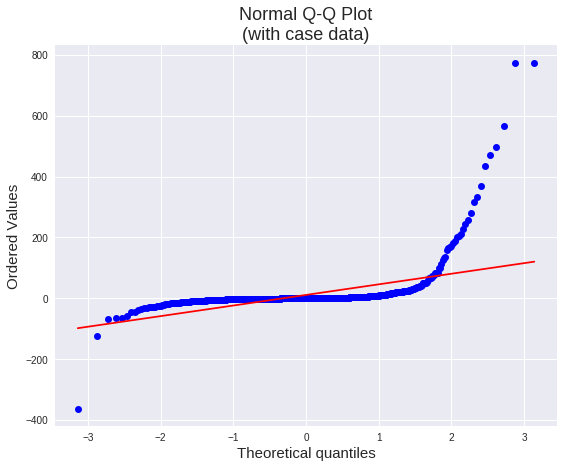

In [689]:
plt.figure(figsize=(9,7))
stats.probplot(exam.loc[exam["county"] != "New York County","residuals"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(with case data)');
# without NYC

Text(0.5, 0, 'Fitted value')

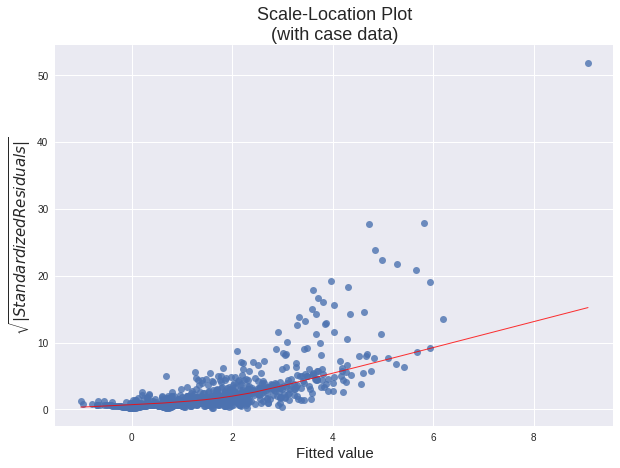

In [690]:
exam["norm_residuals_abs_sqrt"]=np.sqrt(np.abs(exam["residuals"]))

plt.figure(figsize=(10,7))
sns.regplot(exam["fitted"], exam["norm_residuals_abs_sqrt"],
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title("Scale-Location Plot\n(with case data)")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.xlabel("Fitted value")

### Elastic Net

In [697]:
encv = ElasticNetCV(normalize=True, max_iter=60000, random_state=101, cv=10)
encv.fit(abbrev[predictors], abbrev["deaths"])

encv.score(abbrev[predictors], abbrev["deaths"])
# nowhere near .795

# with cv=5, r2=0.236
# with cv=3, r2=0.182
# with cv=7, r2=0.236
# with cv=10, r2=0.236

0.23558938187718192

In [698]:
# try without outlier NYC (collapsed into NY County)
encv = ElasticNetCV(normalize=True, max_iter=6000, random_state=1001, cv=10)
encv.fit(abbrev.loc[abbrev["county"] != "New York County", predictors], 
        abbrev.loc[abbrev["county"] != "New York County", "deaths"])
encv.score(abbrev.loc[abbrev["county"] != "New York County", predictors], 
          abbrev.loc[abbrev["county"] != "New York County", "deaths"])
# slightly better

0.39417487729868766

In [703]:
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, 
                                                            max_iter=6000, 
                                                             l1_ratio=0.5,
                                                            random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[predictors], abbrev["deaths"])
ttr_encv.score(abbrev[predictors], abbrev["deaths"])
# yikes

-19.987645060439778

In [704]:
# try with log-transformed independent variables + transformed dependent variable
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, 
                                                            max_iter=6000, 
                                                             l1_ratio=0.5,
                                                            random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_encv.score(abbrev[log_predictors], abbrev["deaths"])
# better than the non-transformed dependent variable training

0.7940549301908578

In [706]:
for a, b in zip(log_predictors, ttr_encv.regressor_.coef_):
    print(a, "\t", b)

household_size 	 -0.02967139319284012
empl_agriculture 	 -0.0034774557306812234
empl_professional 	 -0.031455078268291324
empl_social 	 -0.000890327718940191
empl_services 	 -0.03593057929915554
empl_manufacturing 	 0.004497746200035591
empl_retail 	 -0.0013119498334486243
prc_fam_poverty 	 0.025967078617103914
avg_income 	 8.624935649744302e-06
prc_public_transp 	 0.04109888027685385
pop_65_plus 	 0.023715121878506586
health_ins 	 0.025821520000539357
prc_obese 	 0.017197460907298883
ten_plus 	 0.060830882241860125
order 	 0.02098585945150849
log_population 	 0.45327142318211433
log_density 	 0.20220924493460407
log_intl_passengers 	 0.010163526489950132
log_domestic_passengers 	 0.0
log_area 	 0.04960435935044561
log_cases_march1 	 -0.439149695942536
log_cases_march15 	 0.1774851841772295


#### ElasticNet with GridSearchCV

In [723]:
param_grid = [{'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}]
enm = ElasticNet(normalize=True, max_iter=60000, random_state=1001)
scorer = make_scorer(r2_score)
search = GridSearchCV(enm, param_grid, cv=3, scoring=scorer).fit(abbrev[predictors], abbrev["deaths"])

In [724]:
search

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=60000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=1001, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(r2_score), verbose=0)

In [725]:
search.best_estimator_ 

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=60000, normalize=True, positive=False, precompute=False,
           random_state=1001, selection='cyclic', tol=0.0001, warm_start=False)

In [726]:
search.best_score_
# yikes, not good, ElasticNetCV 
# with CV=10 l1_ratio=0.9, score=0.057
# with CV=5 l1_ratio=0.9, score=0.072
# with CV=3 l1_ratio=0.9, score=0.105

0.10461834108614053

In [727]:
# try transformed target model with l1_ratio found in grid search

ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(l1_ratio=0.9,
                                                             normalize=True, 
                                                             max_iter=6000, 
                                                             random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[predictors], abbrev["deaths"])
ttr_encv.score(abbrev[predictors], abbrev["deaths"])

-3.2195848273778394

In [728]:
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(l1_ratio=0.9,
                                                             normalize=True, 
                                                             max_iter=6000, 
                                                             random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_encv.score(abbrev[log_predictors], abbrev["deaths"])

# not too far off from the R2 when using default l1_ratio (0.5)

0.757579596961664

In [729]:
for a, b in zip(log_predictors, ttr_encv.regressor_.coef_):
    print(a, "\t", b)

household_size 	 -0.0
empl_agriculture 	 -0.0
empl_professional 	 -0.024994007198917537
empl_social 	 -0.0
empl_services 	 -0.03337371477927095
empl_manufacturing 	 0.004280165035049863
empl_retail 	 -0.0
prc_fam_poverty 	 0.019711736443638547
avg_income 	 2.719633844670381e-06
prc_public_transp 	 0.041526250495517156
pop_65_plus 	 0.0228416984591927
health_ins 	 0.020186867269077775
prc_obese 	 0.014027238929923084
ten_plus 	 0.06319735985349932
order 	 0.020673530285219
log_population 	 0.49080399968147476
log_density 	 0.16314722075646226
log_intl_passengers 	 0.008205763942366
log_domestic_passengers 	 0.0
log_area 	 0.0
log_cases_march1 	 -0.3440336695128418
log_cases_march15 	 0.1599618966965924
